<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/GCN_complete_with_Cora_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.1 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=545106 sha256=e4e69039d956e40b6828c51c04c0add8acac6cb4bb839f5bcb7f44455dcb2720
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1122943 sha256=1255c7109b7cb74dc3dfbee7740383873a4a443

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
from torch_geometric.explain import GNNExplainer

import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

In [5]:
def load_data():
    dataset = Planetoid(root='data/Cora', name='Cora')
    data = dataset[0]

    # Create custom splits using stratified sampling
    indices = np.arange(data.num_nodes)
    train_idx, temp_idx, _, _ = train_test_split(
        indices, data.y.numpy(), stratify=data.y.numpy(), test_size=0.4, random_state=42)
    val_idx, test_idx, _, _ = train_test_split(
        temp_idx, data.y.numpy()[temp_idx], stratify=data.y.numpy()[temp_idx], test_size=0.5, random_state=42)

    train_idx = torch.tensor(train_idx, dtype=torch.long)
    val_idx = torch.tensor(val_idx, dtype=torch.long)
    test_idx = torch.tensor(test_idx, dtype=torch.long)

    return data, train_idx, val_idx, test_idx

In [6]:
def preprocess_features(data):
    scaler = StandardScaler()
    x_np = data.x.numpy()
    x_scaled = scaler.fit_transform(x_np)
    data.x = torch.tensor(x_scaled, dtype=torch.float)
    return data

In [7]:
def handle_missing_data(data):
    x_np = data.x.numpy()
    if np.isnan(x_np).any():
        col_means = np.nanmean(x_np, axis=0)
        inds = np.where(np.isnan(x_np))
        x_np[inds] = np.take(col_means, inds[1])
        data.x = torch.tensor(x_np, dtype=torch.float)
    return data

In [8]:
def encode_categorical_features(data):
    # If needed, implement one-hot encoding here.
    return data

In [9]:
def graph_cleaning(data):
    edge_index = data.edge_index
    edge_array = edge_index.numpy().T  # Shape: [num_edges, 2]
    # Remove duplicate edges
    edge_array = np.unique(edge_array, axis=0)
    # Remove self-loops
    edge_array = edge_array[edge_array[:, 0] != edge_array[:, 1]]
    data.edge_index = torch.tensor(edge_array.T, dtype=torch.long)
    return data

In [10]:
def data_augmentation(data, edge_perturbation_rate=0.05, feature_mask_rate=0.05):
    # Edge perturbation: drop edges with a given probability
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    edge_mask = torch.rand(num_edges) > edge_perturbation_rate
    data.edge_index = edge_index[:, edge_mask]

    # Feature masking: randomly zero-out some feature entries
    feat_mask = torch.rand(data.x.size()) > feature_mask_rate
    data.x = data.x * feat_mask.float()

    return data

In [11]:
def compute_laplacian(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index.numpy()
    row = edge_index[0]
    col = edge_index[1]
    data_values = np.ones(len(row))
    A = sp.coo_matrix((data_values, (row, col)), shape=(num_nodes, num_nodes))
    degrees = np.array(A.sum(axis=1)).flatten()
    D = sp.diags(degrees)
    L = D - A
    return L

In [12]:
def analyze_class_imbalance(data, train_idx):
    y_train = data.y[train_idx].numpy()
    classes, counts = np.unique(y_train, return_counts=True)
    total = len(y_train)
    class_weights = {int(cls): total / count for cls, count in zip(classes, counts)}
    print("Class imbalance analysis:", class_weights)
    return class_weights

In [13]:
def cache_data(data, filename='processed_data.pt'):
    torch.save(data, filename)
    print(f"Data cached to {filename}")

In [14]:
def verify_data_distribution(data, train_idx, val_idx, test_idx):
    print("Train distribution:", np.bincount(data.y[train_idx].numpy()))
    print("Validation distribution:", np.bincount(data.y[val_idx].numpy()))
    print("Test distribution:", np.bincount(data.y[test_idx].numpy()))

**2. Model Architecture Design**

In [15]:
class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5, use_attention=False):
        super(GCNModel, self).__init__()
        self.use_attention = use_attention
        if use_attention:
            self.conv1 = GATConv(in_channels, hidden_channels, heads=1)
            self.conv2 = GATConv(hidden_channels, out_channels, heads=1)
        else:
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Save input for potential residual connection
        identity = x
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        # Add residual connection if dimensions match
        if identity.shape[-1] == x.shape[-1]:
            x = x + identity
        return x

**3. Training & Optimization**

In [16]:
def train(model, optimizer, scheduler, data, train_idx, device, scaler=None):
    model.train()
    optimizer.zero_grad()

    if scaler is not None:
        with torch.cuda.amp.autocast():
            out = model(data.x.to(device), data.edge_index.to(device))
            loss = F.cross_entropy(out[train_idx], data.y[train_idx].to(device))
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer)
        scaler.update()
    else:
        out = model(data.x.to(device), data.edge_index.to(device))
        loss = F.cross_entropy(out[train_idx], data.y[train_idx].to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

    scheduler.step(loss.item())
    return loss.item()

**Explain Function (optional)**

In [17]:
@torch.no_grad()
def evaluate(model, data, mask, device):
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = F.cross_entropy(out[mask], data.y[mask].to(device))
    pred = out[mask].max(dim=1)[1]
    correct = pred.eq(data.y[mask].to(device)).sum().item()
    acc = correct / mask.sum().item()
    return loss.item(), acc, pred.cpu().numpy(), data.y[mask].cpu().numpy()

**Explain Function (optional)**

In [34]:
def explain_node_with_gradients(model, data, node_idx, device):
    model.eval()
    # Clone fitur dan aktifkan perhitungan gradien
    x = data.x.clone().detach().to(device)
    x.requires_grad = True
    edge_index = data.edge_index.to(device)
    out = model(x, edge_index)

    # Tentukan kelas prediksi untuk node target
    pred_class = out[node_idx].argmax().item()
    score = out[node_idx, pred_class]

    model.zero_grad()
    score.backward(retain_graph=True)
    gradients = x.grad[node_idx].cpu().numpy()
    return gradients, pred_class

**4. Post-Training Evaluation**

Laplacian matrix computed.
Train distribution: [210 130 251 491 255 179 108]
Validation distribution: [ 70  43  84 164  85  60  36]
Test distribution: [ 71  44  83 163  86  59  36]
Class imbalance analysis: {0: 7.733333333333333, 1: 12.492307692307692, 2: 6.47011952191235, 3: 3.3075356415478616, 4: 6.368627450980392, 5: 9.072625698324023, 6: 15.037037037037036}
Data cached to processed_cora_data.pt
Epoch 001: Train Loss = 2.1740, Val Loss = 1.8912, Val Acc = 0.0002
Epoch 002: Train Loss = 1.9890, Val Loss = 1.7540, Val Acc = 0.0002
Epoch 003: Train Loss = 1.7264, Val Loss = 1.6224, Val Acc = 0.0003
Epoch 004: Train Loss = 1.5920, Val Loss = 1.4974, Val Acc = 0.0004
Epoch 005: Train Loss = 1.4234, Val Loss = 1.3805, Val Acc = 0.0005
Epoch 006: Train Loss = 1.2877, Val Loss = 1.2726, Val Acc = 0.0005
Epoch 007: Train Loss = 1.1444, Val Loss = 1.1744, Val Acc = 0.0006
Epoch 008: Train Loss = 1.0548, Val Loss = 1.0863, Val Acc = 0.0006
Epoch 009: Train Loss = 0.9394, Val Loss = 1.0079, Val

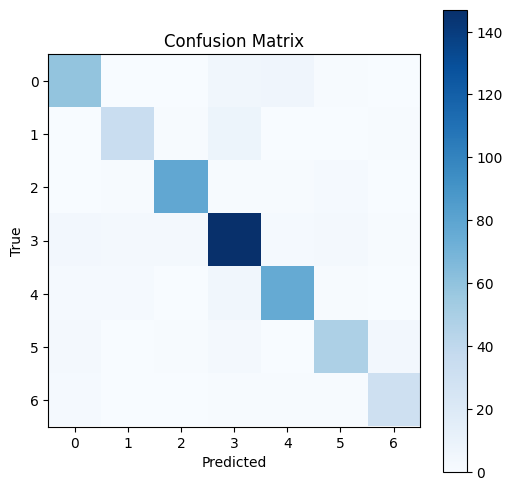

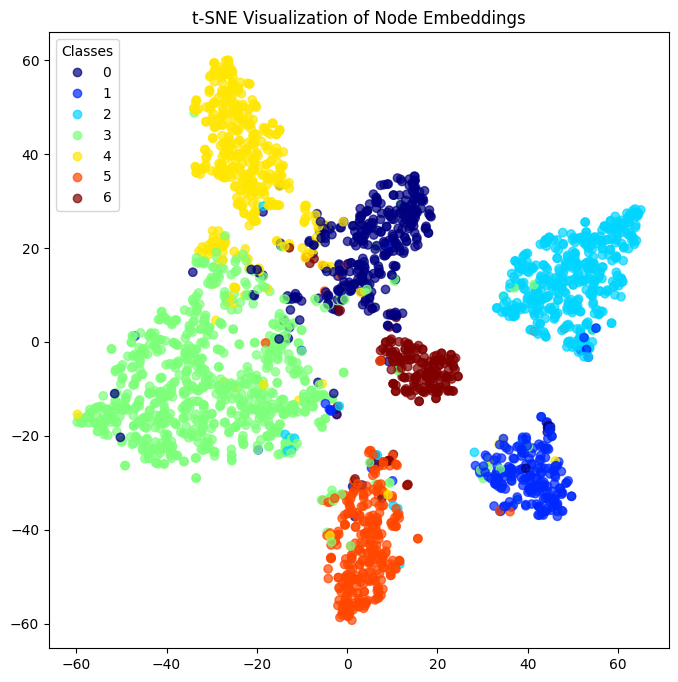

In [36]:
def main():
    # Set device and random seeds
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(42)
    np.random.seed(42)

    # --- Data Preprocessing ---
    data, train_idx, val_idx, test_idx = load_data()
    data = preprocess_features(data)
    data = handle_missing_data(data)
    data = encode_categorical_features(data)
    data = graph_cleaning(data)
    data = data_augmentation(data, edge_perturbation_rate=0.05, feature_mask_rate=0.05)
    laplacian = compute_laplacian(data)
    print("Laplacian matrix computed.")
    verify_data_distribution(data, train_idx, val_idx, test_idx)
    class_weights = analyze_class_imbalance(data, train_idx)
    cache_data(data, filename='processed_cora_data.pt')

    # --- Model Architecture ---
    num_features = data.x.size(1)
    num_classes = int(data.y.max().item()) + 1
    model = GCNModel(in_channels=num_features,
                     hidden_channels=64,
                     out_channels=num_classes,
                     dropout=0.5,
                     use_attention=False)
    model = model.to(device)

    # --- Training & Optimization ---
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 20
    num_epochs = 200

    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, optimizer, scheduler, data, train_idx, device, scaler)
        val_loss, val_acc, _, _ = evaluate(model, data, val_idx, device)
        print(f"Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break

    # Load best model and evaluate on the test set
    model.load_state_dict(best_model_state)
    test_loss, test_acc, test_pred, test_true = evaluate(model, data, test_idx, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(classification_report(test_true, test_pred))

    # --- Post-Training & Evaluation ---
    # Confusion Matrix Visualization
    cm = confusion_matrix(test_true, test_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # t-SNE Visualization of Node Embeddings
    model.eval()
    embeddings = model(data.x.to(device), data.edge_index.to(device)).detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=data.y.numpy(), cmap='jet', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("t-SNE Visualization of Node Embeddings")
    plt.show()

if __name__ == "__main__":
    main()